# M1 MIAGE SBD
##@Authors : Aline N'DEKO & Franck LAGOU
## Kickstarter for final project "Differential privacy"

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns
import numpy as np
from numpy.random import laplace


## Loading data

In [87]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
         'marital-status', 'occupation', 'relationship', 'race',
         'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
         'native-country', 'income']

adult = pd.read_csv(url, sep=',', header=None, names=names, na_values='?', engine='python', skipinitialspace=True)

adult.dropna(inplace=True)
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


## Performing queries

### Query H1: Distribution (histogram) of the education level.

In [88]:
adult['education'].value_counts()

education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: count, dtype: int64

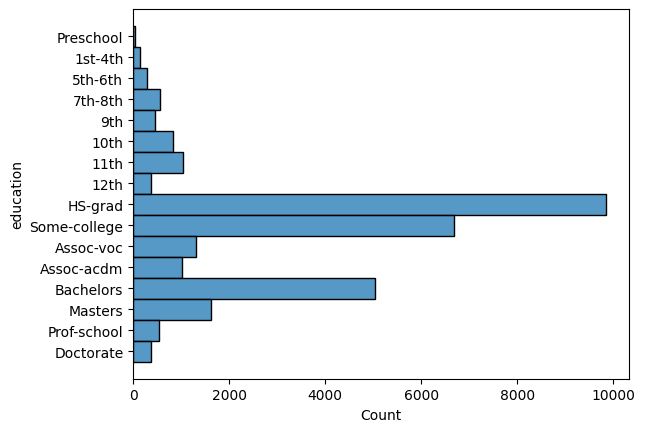

In [89]:
sns.histplot(data=adult.sort_values(by='education-num'), y='education');

##I- Privelet Algorithm

#Q1 : Implement the 1-dimensional Privelet algorithm described in the Section 4 “Privelet for one-dimensional
ordinal data”

In [90]:
import numpy as np
from numpy.random import laplace

# === Étape 1 : Transformation de Haar Wavelet ===
def haar_wavelet_transform(data):
    """
    Applique la Haar Wavelet Transform (HWT) à une liste de données.
    Retourne les coefficients (base + internes).
    """
    data = np.array(data, dtype=float)
    n = len(data)
    coeffs = []

    def build_tree(segment):
        if len(segment) == 1:
            return segment[0]
        mid = len(segment) // 2
        left_avg = np.mean(segment[:mid])
        right_avg = np.mean(segment[mid:])
        coeff = (left_avg - right_avg) / 2
        coeffs.append(coeff)
        build_tree(segment[:mid])
        build_tree(segment[mid:])
        return coeff

    # Base coefficient (c0) = moyenne globale
    base_coeff = np.mean(data)
    coeffs.insert(0, base_coeff)
    build_tree(data)
    return coeffs


In [91]:
# === Étape 3
def compute_whaar_weights(num_coeffs):
    """
    Calcule les poids WHaar des coefficients pour Privelet.
    Cette version corrige les problèmes de boucles infinies et assure que num_coeffs est une puissance de 2.
    """
    # Vérification que num_coeffs est une puissance de 2
    if (num_coeffs & (num_coeffs - 1)) != 0:  # Si ce n'est pas une puissance de 2
        raise ValueError("num_coeffs doit être une puissance de 2")
    
    weights = []
    l = int(np.log2(num_coeffs))  # Calcul de l
    
    weights.append(2**l)  # Le poids du coefficient de base (c0)
    
    level = 1
    remaining = num_coeffs - 1  # Reste à traiter après le coefficient de base
    
    while remaining > 0:
        # Calcul du nombre de nœuds à ce niveau
        nodes_at_level = 2**(level - 1)
        
        # Ajouter des poids pour chaque nœud à ce niveau
        for _ in range(nodes_at_level):
            if len(weights) < num_coeffs:
                weights.append(2**(l - level + 1))
        
        # Réduire le nombre restant à traiter
        remaining -= nodes_at_level
        level += 1
    
    return weights


In [92]:
import numpy as np
from numpy.random import laplace

# === Étape 3 : Ajout du bruit Laplacien calibré ===
def add_laplace_noise(coeffs, epsilon):
    """
    Ajoute du bruit Laplacien aux coefficients Haar en fonction de WHaar.
    """
    weights = compute_whaar_weights(len(coeffs))
    noisy_coeffs = []
    lambda_ = (1 + np.log2(len(weights))) / epsilon  # Très important
    for c, w in zip(coeffs, weights):
        scale = lambda_ / w  # Ajustement correct
        noisy_coeffs.append(c + laplace(scale=scale))
    return noisy_coeffs


In [93]:
import numpy as np
from numpy.random import laplace
# === Étape 4 : Reconstruction des données originales ===
def inverse_haar_wavelet_transform(coeffs):
    """
    Reconstitue les données à partir des coefficients Haar.
    """
    n = len(coeffs)  # nombre total de coefficients (ici 8)
    levels = int(np.log2(n))  # le nombre de niveaux

    # Initialiser les valeurs avec le premier coefficient (la moyenne)
    reconstructed = np.array([coeffs[0]])

    # Décoder chaque niveau et doubler la taille à chaque fois
    idx = 1
    for level in range(levels):
        new_reconstructed = []
        for val in reconstructed:
            diff = coeffs[idx]
            new_reconstructed.append(val + diff)
            new_reconstructed.append(val - diff)
            idx += 1
        reconstructed = np.array(new_reconstructed)

    return reconstructed


In [94]:
import numpy as np
from numpy.random import laplace

# === Privelet Algorithm (Final Function) ===
def privelet_transform(data, epsilon):
    """
    Implémente le Privelet transform (1D) pour données ordinales.
    """
    coeffs = haar_wavelet_transform(data)
    noisy_coeffs = add_laplace_noise(coeffs, epsilon)
    noisy_data = inverse_haar_wavelet_transform(noisy_coeffs)
    return noisy_data, noisy_coeffs


In [95]:

# Données de test (longueur = 8 = 2^3)
original_data = [9, 3, 6, 2, 8, 4, 5, 7]
epsilon = 1.0  # niveau de confidentialité

print("=== Données originales ===")
print(original_data)

=== Données originales ===
[9, 3, 6, 2, 8, 4, 5, 7]


In [96]:

# Étape 1 : Transformation de Haar
coeffs = haar_wavelet_transform(original_data)
print("\n=== Coefficients Haar ===")
print(np.round(coeffs, 3))


=== Coefficients Haar ===
[ 5.5 -0.5  1.   3.   2.   0.   2.  -1. ]


In [97]:
# Étape 2 : Poids WHaar
weights = compute_whaar_weights(len(coeffs))
print("\n=== Poids WHaar ===")
print(weights)


=== Poids WHaar ===
[8, 8, 4, 4, 2, 2, 2, 2]


In [98]:
# Étape 3 : Ajout de bruit
noisy_coeffs = add_laplace_noise(coeffs, epsilon)
print("\n=== Coefficients bruités ===")
print(np.round(noisy_coeffs, 3))


=== Coefficients bruités ===
[ 5.813 -0.759  1.63   2.947  1.272  0.54  -0.988  0.104]


In [99]:

# Reconstruction des données à partir des coefficients bruités
reconstructed = inverse_haar_wavelet_transform(noisy_coeffs)

print("\n=== Données reconstruites (bruitées) ===")
print(np.round(reconstructed, 2))


=== Données reconstruites (bruitées) ===
[ 7.96  5.41  3.96  2.88  8.53 10.51  3.73  3.52]


In [100]:
# Comparaison avec reconstruction sans bruit (pour valider l’algo)
perfect_reconstruction = inverse_haar_wavelet_transform(coeffs)
print("\n=== Reconstruction sans bruit (pour validation) ===") 
print(np.round(perfect_reconstruction, 2))


=== Reconstruction sans bruit (pour validation) ===
[ 8.  4.  4.  4. 11.  7.  2.  4.]


Q2: Test your code with Privelet to compute query H1 with ² 2 {0.01,0.1,1} (all other parameters set to default
values).



On doit :

Extraire la colonne "education",

Construire l'histogramme (compter combien par niveau d'éducation),

Appliquer Privelet (Haar + bruit Laplace + inverse),

Tester pour epsilon ∈ {0.01, 0.1, 1},

Imprimer les résultats.

In [101]:
# Extraire l'histogramme "education"
education_counts = adult['education'].value_counts().sort_index()
labels = education_counts.index.tolist()
edu_true_histogram = education_counts.values
edu_true_histogram

array([ 820, 1048,  377,  151,  288,  557,  455, 1008, 1307, 5044,  375,
       9840, 1627,   45,  542, 6678])

In [108]:
#
def pad_to_power_of_two(arr):
    next_pow2 = 2**int(np.ceil(np.log2(len(arr))))
    padded = np.zeros(next_pow2)
    padded[:len(arr)] = arr
    return padded

edu_original_data = pad_to_power_of_two(edu_true_histogram)

edu_original_data


array([ 820., 1048.,  377.,  151.,  288.,  557.,  455., 1008., 1307.,
       5044.,  375., 9840., 1627.,   45.,  542., 6678.])

In [109]:
#Tester pour différents epsilon
edu_epsilons = [0.01, 0.1, 1]

for edu_epsilon in edu_epsilons:
    print(f"\n==================================== Résultats pour ε = {edu_epsilon} =================================")

    # 1-Appliquer Haar
    edu_coeffs = haar_wavelet_transform(edu_original_data)

    # 2-Calculer poids
    edu_weights = compute_whaar_weights(len(edu_coeffs))

    # 3-Ajouter bruit Laplace
    edu_noisy_coeffs = add_laplace_noise(edu_coeffs, edu_epsilon)
    
    # 4-Reconstruire l'histogramme bruité
    edu_reconstructed = inverse_haar_wavelet_transform(edu_noisy_coeffs)
    
    # 🔥 Ajouter affichage
    print("Histogramme reconstruit bruité :")
    print(np.round(edu_reconstructed, 2))



==================================== Résultats pour ε = 0.01 =================================
Histogramme reconstruit bruité :
[  937.22  1257.58   869.1   -109.72   -54.7   1848.45 -1643.    2621.63
 -1496.54  8585.91  2330.84  5067.87  3512.9   1937.82  -307.53  5657.38]

==================================== Résultats pour ε = 0.1 =================================
Histogramme reconstruit bruité :
[  225.27   706.17  1733.89  -246.76  -257.85  1624.41 -1489.83  2365.29
 -1326.1   8063.22  2303.82  5015.03  3450.36  1943.15   -49.58  6009.6 ]

==================================== Résultats pour ε = 1 =================================
Histogramme reconstruit bruité :
[  208.93   763.45  1669.43  -249.12  -277.7   1655.98 -1402.08  2333.77
 -1371.6   8097.89  2285.95  5052.2   3498.73  1922.95   -80.22  6049.29]


#### Une represenntation graphique de l'histogramme d'origine et de l'histogramme bruité

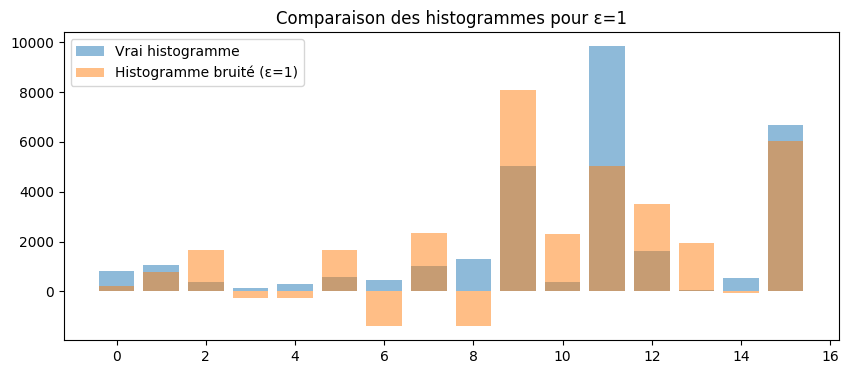

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(range(len(edu_original_data)), edu_original_data, alpha=0.5, label='Vrai histogramme')
plt.bar(range(len(edu_reconstructed)), edu_reconstructed, alpha=0.5, label=f'Histogramme bruité (ε={edu_epsilon})')
plt.title(f'Comparaison des histogrammes pour ε={edu_epsilon}')
plt.legend()
plt.show()
